# AMATH 515 Homework 2

**Due Date: 02/08/2019**

* Name: Aleksei Sholokhov
* Student Number: 1822506

*Homework Instruction*: Please follow order of this notebook and fill in the codes where commented as `TODO`.

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [7]:
from numpy.linalg import norm

## Please complete the solvers in `solver.py`

In [4]:
import sys
sys.path.append('./')
from solvers import *

## Problem 3: Compressive Sensing

Consier the optimization problem,

$$
\min_x~~\frac{1}{2}\|Ax - b\|^2 + \lambda\|x\|_1
$$

In the following, please specify the $f$ and $g$ and use the proximal gradient descent solver to obtain the solution.

In [6]:
# create the data
np.random.seed(123)
m = 100  # number of measurements
n = 500  # number of variables
k = 10   # number of nonzero variables
s = 0.05 # measurements noise level
#
A_cs = np.random.randn(m, n)
x_cs = np.zeros(n)
x_cs[np.random.choice(range(n), k, replace=False)] = np.random.choice([-1.0, 1.0], k)
b_cs = A_cs.dot(x_cs) + s*np.random.randn(m)
#
lam_cs = 0.1*norm(A_cs.T.dot(b_cs), np.inf)

In [62]:
# define the function, prox and the beta constant
def func_f_cs(x):
    return 1/2*norm(A_cs.dot(x) - b_cs)**2

def func_g_cs(x):
    return lam_cs*norm(x, ord=1)

def grad_f_cs(x):
    return A_cs.T.dot(A_cs.dot(x) - b_cs)

def prox_g_cs(x, t):
    return (x - t*lam_cs).clip(0, None) - (- x - t*lam_cs).clip(0, None)

# TODO: what is the beta value for the smooth part
eigvalues, _ = np.linalg.eig(A_cs.T.dot(A_cs))
beta_f_cs = max(abs(eigvalues))

In [63]:
beta_f_cs

1018.2382248413569

### Proximal gradient descent on compressive sensing

In [64]:
# apply the proximal gradient descent solver
x0_cs_pgd = np.zeros(x_cs.size)
x_cs_pgd, obj_his_cs_pgd, err_his_cs_pgd, exit_flag_cs_pgd = \
    optimizeWithPGD(x0_cs_pgd, func_f_cs, func_g_cs, grad_f_cs, prox_g_cs, beta_f_cs)

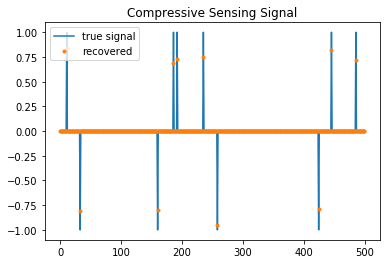

In [65]:
# plot signal result
plt.plot(x_cs)
plt.plot(x_cs_pgd, '.')
plt.legend(['true signal', 'recovered'])
plt.title('Compressive Sensing Signal')
plt.show()

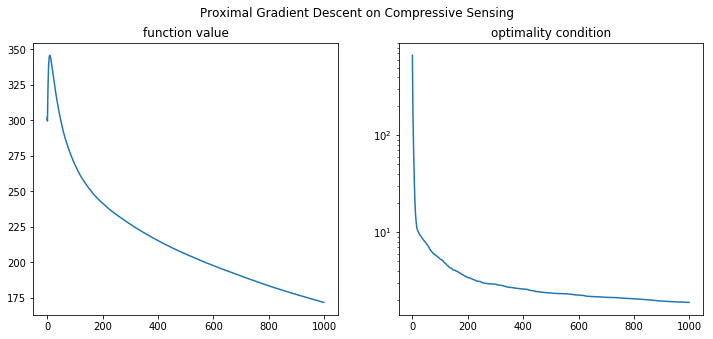

In [23]:
# plot result
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(obj_his_cs_pgd)
ax[0].set_title('function value')
ax[1].semilogy(err_his_cs_pgd)
ax[1].set_title('optimality condition')
fig.suptitle('Proximal Gradient Descent on Compressive Sensing')
plt.show()

### Accelerate proximal gradient descent on compressive sensing

In [30]:
# apply the proximal gradient descent solver
x0_cs_apgd = np.zeros(x_cs.size)
x_cs_apgd, obj_his_cs_apgd, err_his_cs_apgd, exit_flag_cs_apgd = \
    optimizeWithAPGD(x0_cs_apgd, func_f_cs, func_g_cs, grad_f_cs, prox_g_cs, beta_f_cs)

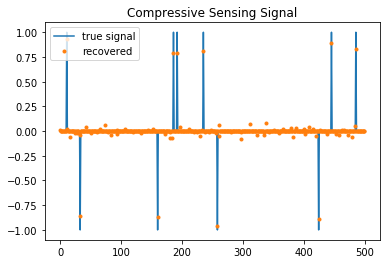

In [31]:
# plot signal result
plt.plot(x_cs)
plt.plot(x_cs_pgd, '.')
plt.legend(['true signal', 'recovered'])
plt.title('Compressive Sensing Signal')
plt.show()

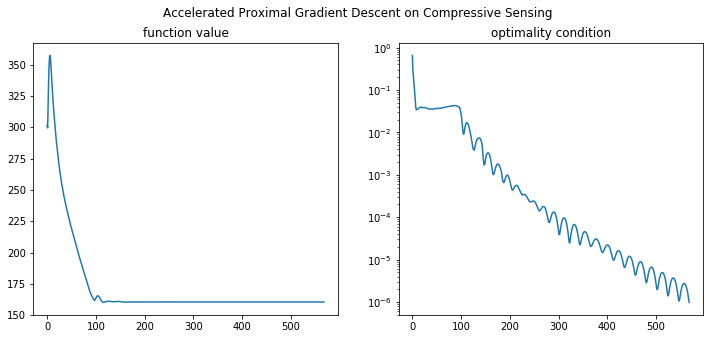

In [32]:
# plot result
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(obj_his_cs_apgd)
ax[0].set_title('function value')
ax[1].semilogy(err_his_cs_apgd)
ax[1].set_title('optimality condition')
fig.suptitle('Accelerated Proximal Gradient Descent on Compressive Sensing')
plt.show()

## Problem 4: Logistic Regression on MINST Data

Now let's play with some real data, recall the logistic regression problem,

$$
\min_x~~\sum_{i=1}^m\left\{\log(1 + \exp(\langle a_i,x \rangle)) - b_i\langle a_i,x \rangle\right\} + \frac{\lambda}{2}\|x\|^2.
$$

Here our data pair $\{a_i, b_i\}$, $a_i$ is the image and $b_i$ is the label.
In this homework problem, let's consider the binary classification problem, where $b_i \in \{0, 1\}$.

In [36]:
# import data
mnist_data = np.load('mnist01.npy')
#
A_lgt = mnist_data[0]
b_lgt = mnist_data[1]
A_lgt_test = mnist_data[2]
b_lgt_test = mnist_data[3]
#
# set regularizer parameter
lam_lgt = 0.1
#
# beta constant of the function
beta_lgt = 0.25*norm(A_lgt, 2)**2 + lam_lgt

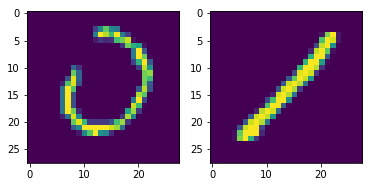

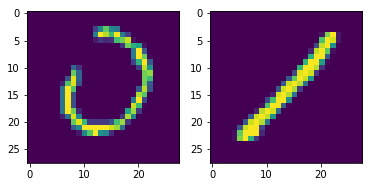

In [37]:
# plot the images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(A_lgt[0].reshape(28,28))
ax[1].imshow(A_lgt[7].reshape(28,28))
plt.show()

In [49]:
import scipy as sp
from scipy.special import expit

In [50]:
# define function, gradient and Hessian
def lgt_func(x):
    return lam_lgt/2*x.dot(x) + np.logaddexp(0, A_lgt.dot(x)).sum() - \
        b_lgt.dot(A_lgt.dot(x)).sum()

def lgt_grad(x):
    return lam_lgt*x + A_lgt.T.dot(sp.special.expit(A_lgt.dot(x))) - \
        A_lgt.T.dot(b_lgt)
#
def lgt_hess(x):
    return lam_lgt*np.eye(len(x)) + \
        A_lgt.T.dot(np.diag(expit(A_lgt.dot(x))*expit(-A_lgt.dot(x)))).dot(A_lgt)

### Gradient decsent on logistic regression

In [51]:
# apply the gradient descent
x0_lgt_gd = np.zeros(A_lgt.shape[1])
x_lgt_gd, obj_his_lgt_gd, err_his_lgt_gd, exit_flag_lgt_gd = \
    optimizeWithGD(x0_lgt_gd, lgt_func, lgt_grad, beta_lgt)

Gradient descent reach maximum number of iteration.


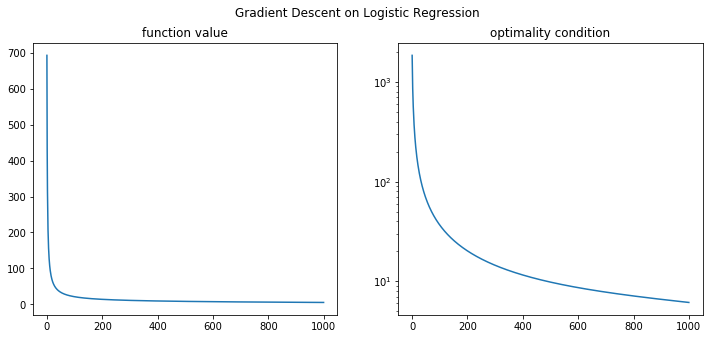

In [52]:
# plot result
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(obj_his_lgt_gd)
ax[0].set_title('function value')
ax[1].semilogy(err_his_lgt_gd)
ax[1].set_title('optimality condition')
fig.suptitle('Gradient Descent on Logistic Regression')
plt.show()

### Accelerate Gradient decsent on logistic regression

In [53]:
# apply the accelerated gradient descent
x0_lgt_agd = np.zeros(A_lgt.shape[1])
x_lgt_agd, obj_his_lgt_agd, err_his_lgt_agd, exit_flag_lgt_agd = \
    optimizeWithAGD(x0_lgt_agd, lgt_func, lgt_grad, beta_lgt)

Proximal gradient descent reach maximum of iteration


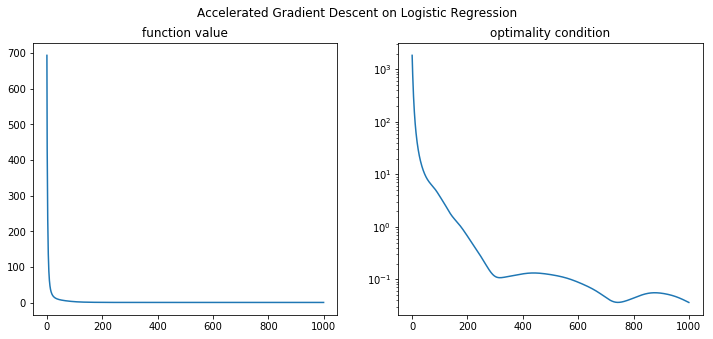

In [54]:
# plot result
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(obj_his_lgt_agd)
ax[0].set_title('function value')
ax[1].semilogy(err_his_lgt_agd)
ax[1].set_title('optimality condition')
fig.suptitle('Accelerated Gradient Descent on Logistic Regression')
plt.show()

### Newton Method on logistic regression

In [55]:
# apply the accelerated gradient descent
x0_lgt_nt = np.zeros(A_lgt.shape[1])
x_lgt_nt, obj_his_lgt_nt, err_his_lgt_nt, exit_flag_lgt_nt = \
    optimizeWithNT(x0_lgt_nt, lgt_func, lgt_grad, lgt_hess)

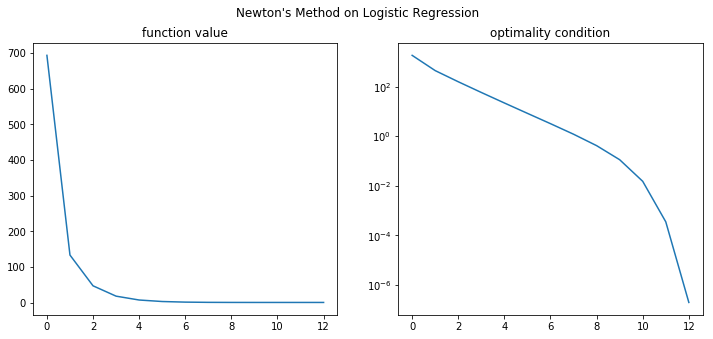

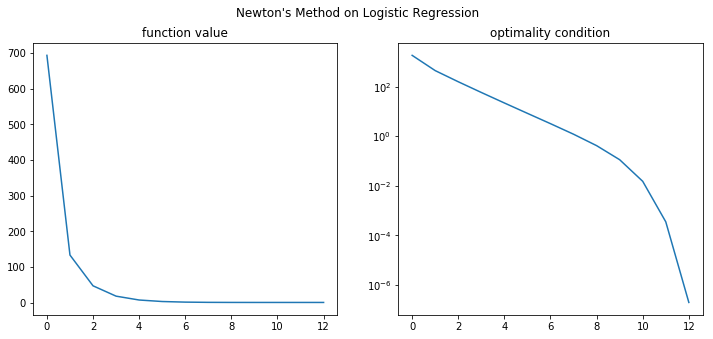

In [57]:
# plot result
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(obj_his_lgt_nt)
ax[0].set_title('function value')
ax[1].semilogy(err_his_lgt_nt)
ax[1].set_title('optimality condition')
fig.suptitle('Newton\'s Method on Logistic Regression')
plt.show()

### Test Logistic Regression

In [58]:
# define accuracy function
def accuracy(x, A_test, b_test):
    r = A_test.dot(x)
    b_test[b_test == 0.0] = -1.0
    correct_count = np.sum((r*b_test) > 0.0)
    return correct_count/b_test.size

In [59]:
print('accuracy of the result is %0.3f' % accuracy(x_lgt_nt, A_lgt_test, b_lgt_test))

accuracy of the result is 1.000
